In [1]:
from sage.all import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

In [2]:
def DesarguesSpread(F):
    lines = [[(F(0),u) for u in F]]
    for m in F:
        lines.append([(u, m*u) for u in F])
    return lines

In [3]:
def toInt(e):
    return list(F).index(e)

In [4]:
mubs = np.load('MUBS/2-2-desarguesian.npy')
mubs.shape

(20, 4)

In [5]:
F = GF(2**2, 'a')
list(F)

[0, a, a + 1, 1]

In [6]:
def A_lines(x,y):
    bs = [y - m*x for m in F]
    lines = [[(x, u) for u in F]]
    for i, m in enumerate(F):
        line = [(x, m*x + bs[i]) for x in F]
        lines.append(line)
    return lines

In [7]:
def affineAx(F):
    d = F.order()
    fig, ax = plt.subplots(figsize=(3.5,3.5))

    ax.set_xticks(range(d))
    ax.set_yticks(range(d))

    # labels = ['$' + str(e) + '$' for e in F]
    # labels = list(F)
    labels = ['0', r'$\alpha$', r'$\alpha + 1$', '1']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    return fig, ax

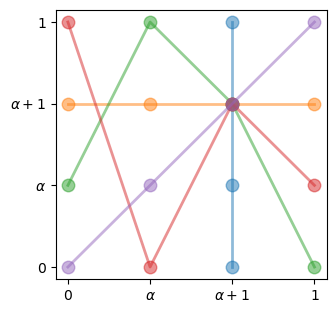

In [15]:
fig, ax = affineAx(F)

f = list(F)
lines = A_lines(f[2], f[2])
for i, line in enumerate(lines):
    x, y = np.array(line).T
    x = [toInt(e) for e in x]
    y = [toInt(e) for e in y]

    alpha = 0.5
    # if i in [0,1,9,27]:
    #     alpha = 0.9

    ax.plot(
        x, y,
        marker='o',
        linewidth=2,
        markersize=9,
        alpha=alpha
    )

In [9]:
mpl.get_backend()

'module://matplotlib_inline.backend_inline'

Saving to PGF file format.

In [25]:
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [27]:
plt.savefig('../imgs/affine-desargues-2-2-Wootters.pgf')

In [16]:
def npProj(v):
    d = len(v)
    return np.kron(v.reshape((d,1)), v.conj())

In [19]:
def A(x, y, mubs):
    d = F.order()
    bs = [x] + [y - m*x for m in F]
    bi = [toInt(b) for b in bs]
    
    op = np.zeros((d,d), dtype='complex64')
    for k in range(d + 1):
        B = mubs[d*k:d*(k+1),:]
        p = npProj(B[:,bi[k]])
        op += p
        
    return op - identity_matrix(d)

In [22]:
op = A(0,0,mubs) 
print(op.trace())
print(np.all(op == op.conj().T))

(1+0j)
True


In [23]:
op

array([[1. +0.j , 0. +0.5j, 0. +0.5j, 0. +0.5j],
       [0. -0.5j, 0. +0.j , 0.5+0.j , 0.5+0.j ],
       [0. -0.5j, 0.5+0.j , 0. +0.j , 0.5+0.j ],
       [0. -0.5j, 0.5+0.j , 0.5+0.j , 0. +0.j ]])

In [24]:
def Wigner(rho, x, y):
    d = F.order()
    return (rho @ A(x, y, mubs)).trace() / d

In [25]:
def WignerMatrix(rho):
    d = rho.shape[0]
    W = np.zeros((d,d))
    for i, x in enumerate(F):
        for j, y in enumerate(F):
            W[i,j] = np.real(Wigner(rho, x, y))
    return np.rot90(W)

In [34]:
WignerMatrix(npProj(mubs[:4,0]))

array([[0.25, 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.  ]])

In [78]:
def plotWigner(M, rotate=True):
    if rotate:
        M = np.rot90(M, -1)

    n = np.size(M)
    xpos, ypos = np.meshgrid(range(M.shape[0]), range(M.shape[1]))
    xpos = xpos.T.flatten() - 0.5
    ypos = ypos.T.flatten() - 0.5
    zpos = np.zeros(n)
    dx = dy = 0.8 * np.ones(n)
    dz = np.real(M.flatten())

    z_min = min(dz)
    z_max = max(dz)
    if z_min == z_max:
        z_min -= 0.1
        z_max += 0.1

    norm = mpl.colors.Normalize(z_min, z_max)
    cmap = mpl.colormaps['viridis']
    colors = cmap(norm(dz))

    fig = plt.figure(figsize=(4.5, 3.5))
    # ax = fig.add_subplot(projection='3d', azim=145, elev=35)
    ax = fig.add_subplot(projection='3d', azim=-35, elev=35)

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)

    # x axis
    ax.axes.xaxis.set_major_locator(plt.IndexLocator(1, -0.1))

    # y axis
    ax.axes.yaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    # ax.invert_yaxis()

    labels_x = [r'$\uparrow\uparrow$',
              r'$\uparrow\downarrow$',
              r'$\downarrow\uparrow$',
              r'$\downarrow\downarrow$']
    labels_y = [r'$\rightarrow\rightarrow$',
              r'$\rightarrow\leftarrow$',
              r'$\leftarrow\rightarrow$',
              r'$\leftarrow\leftarrow$']
    ax.set_xticklabels(labels_x)
    ax.set_yticklabels(labels_y)

    # z axis
    ax.axes.zaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.set_zlim3d([min(z_min, 0), z_max])

    cax, kw = mpl.colorbar.make_axes(ax, shrink=.75, pad=.1)
    mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

    return fig, ax

In [81]:
plotWigner(WignerMatrix(npProj(mubs[:4,0])))

/var/folders/33/k06yq9x95jqcnbk_bh41j4qc0000gn/T/ipykernel_71370/605680074.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_x)
/var/folders/33/k06yq9x95jqcnbk_bh41j4qc0000gn/T/ipykernel_71370/605680074.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels_y)


(<Figure size 450x350 with 2 Axes>, <Axes3D: >)

In [80]:
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [82]:
plt.savefig('../imgs/wigner-desargues-2-2-s1.pgf')

In [97]:
s = mubs[0:4,1] + mubs[0:4,2]
s = s / np.linalg.norm(s)
npProj(s)

array([[0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.49999997+0.j, 0.49999997+0.j, 0.        +0.j],
       [0.        +0.j, 0.49999997+0.j, 0.49999997+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j]],
      dtype=complex64)

In [98]:
plotWigner(WignerMatrix(npProj(s)))

/var/folders/33/k06yq9x95jqcnbk_bh41j4qc0000gn/T/ipykernel_71370/605680074.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_x)
/var/folders/33/k06yq9x95jqcnbk_bh41j4qc0000gn/T/ipykernel_71370/605680074.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels_y)


(<Figure size 450x350 with 2 Axes>, <Axes3D: >)

In [99]:
plt.savefig('../imgs/wigner-desargues-2-2-s2.pgf')

In [100]:
mubs[4:8]

array([[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j],
       [ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
       [ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j],
       [ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j]], dtype=complex64)

In [104]:
WignerMatrix(npProj(mubs[12:16,0]))

array([[0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25],
       [0.  , 0.  , 0.25, 0.  ],
       [0.25, 0.  , 0.  , 0.  ]])

In [106]:
mpl.use('module://matplotlib_inline.backend_inline')

/var/folders/33/k06yq9x95jqcnbk_bh41j4qc0000gn/T/ipykernel_71370/605680074.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels_x)
/var/folders/33/k06yq9x95jqcnbk_bh41j4qc0000gn/T/ipykernel_71370/605680074.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels_y)


(<Figure size 450x350 with 2 Axes>, <Axes3D: >)

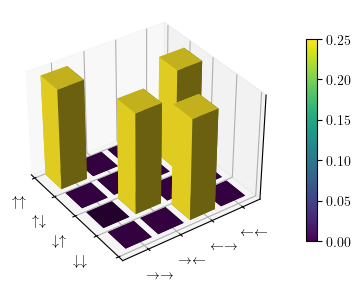

In [107]:
plotWigner(WignerMatrix(npProj(mubs[12:16,0])))